In [1]:
# !pip install -e ../../

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from generation.config import SIGNALS_TRAINING_CONFIG as CONFIG
from generation.dataset.signals_dataset import SignalsDataset
# from generation.nets.signals_net import Generator, Discriminator
from generation.training.wgan_trainer import WganTrainer
from generation.utils import set_seed

set_seed()

2020-12-19 05:35:47.475 | INFO     | generation.utils:set_seed:14 - Set seed 42


In [3]:
config = CONFIG

dataset = SignalsDataset(signal_dim=config['x_dim'])

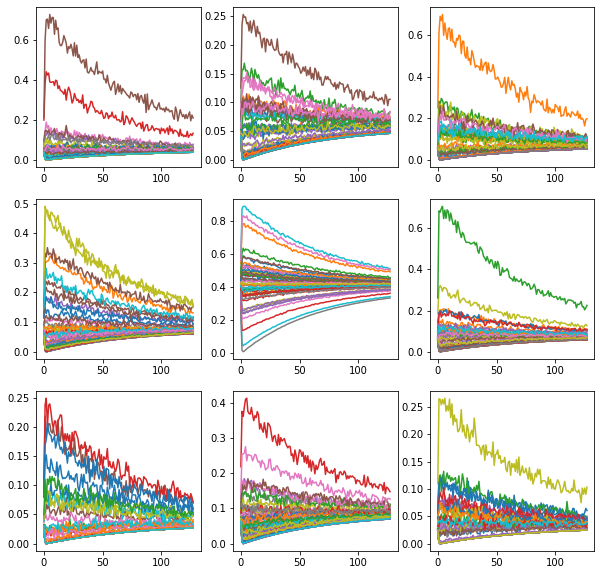

In [4]:
f, ax = plt.subplots(3, 3, figsize=(10, 10))


for _ in range(50):
    noises = dataset[np.random.choice(range(len(dataset)))]
    for i in range(9):
        ax[i // 3][i % 3].plot(noises[i])
plt.show()

In [5]:
dataset.noises.shape

(9, 8310, 128)

In [6]:
import torch
import torch.nn as nn


DETECTORS_NUM = 9
SEQ_LEN = 128
HIDDEN_SIZE=8


class LstmDiscriminator(nn.Module):
    def __init__(self, inp_size=DETECTORS_NUM, hid_size=HIDDEN_SIZE):
        super(LstmDiscriminator, self).__init__()
        self.lstm = nn.LSTM(input_size=inp_size, hidden_size=hid_size, batch_first=True)
        self.linear = nn.Linear(hid_size, 1)
    
    def forward(self, x, debug=False):
        def _debug():
            if debug:
                print(x.shape)
        
        x = x.permute(0, 2, 1)
        _debug()
        x, _ = self.lstm(x)
        _debug()
        x = torch.mean(x, dim=1)
        _debug()
        x = self.linear(x)
        _debug()
        return x

In [7]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import wandb

class LinearGenerator(nn.Module):
    def __init__(self, config):
        super(LinearGenerator, self).__init__()
        self.x_dim = config['x_dim']
        self.z_dim = config['z_dim']

        self.fc0 = nn.Linear(self.z_dim, self.z_dim * 9)
        self.fc1 = nn.Linear(self.z_dim, self.x_dim // 16)
        self.fc2 = nn.Linear(self.x_dim // 16, self.x_dim // 4)
        self.fc3 = nn.Linear(self.x_dim // 4, self.x_dim)

        self.batchnorm1 = nn.BatchNorm1d(self.x_dim // 16)
        self.batchnorm2 = nn.BatchNorm1d(self.x_dim // 4)

    def forward(self, x, debug=False):
        def _debug():
            if debug:
                print(x.shape)

        x = F.tanh(self.fc0(x))
        _debug()
        x = x.view(-1, 9, self.z_dim)
        _debug()
        x = F.tanh(self.fc1(x))
        _debug()
        x = F.tanh(self.fc2(x))
        _debug()
        x = torch.sigmoid(self.fc3(x))
        _debug()
        return x


    @staticmethod
    def visualize(generated, real, epoch):
        generated_sample = generated[0].cpu().data
        real_sample = real[0].cpu().data

        fig, ax = plt.subplots(3, 3, figsize=(10, 10))
        for i in range(9):
            ax[i // 3][i % 3].plot(generated_sample[i])
        wandb.log({"Generated": fig})
        plt.clf()

In [8]:
# disc = LstmDiscriminator()
# test_input = dataset[0].unsqueeze(0).permute(0, 2, 1)
# disc(test_input, debug=True)

In [9]:
torch.backends.cudnn.flags(enabled=False)

In [10]:
generator = LinearGenerator(config)
discriminator = LstmDiscriminator()
g_optimizer = torch.optim.Adam(generator.parameters(), lr=config['g_lr'])
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=config['d_lr'])

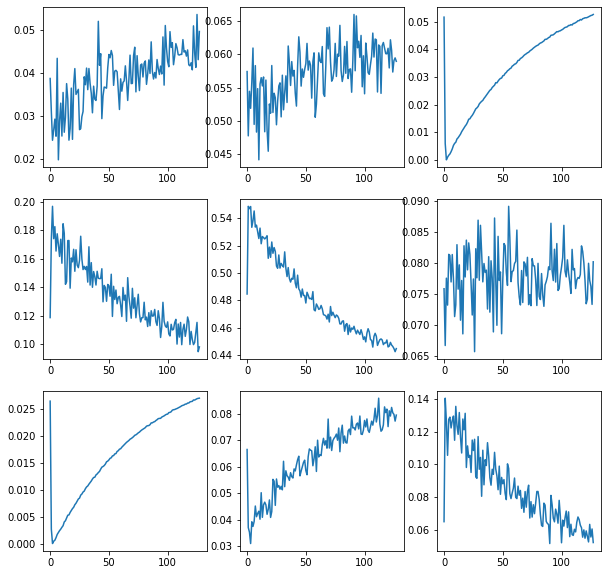

In [11]:
f, ax = plt.subplots(3, 3, figsize=(10, 10))

noises = dataset[40]

for i in range(9):
    ax[i // 3][i % 3].plot(noises[i])

In [12]:
trainer = WganTrainer(generator, discriminator, g_optimizer, d_optimizer, config)
trainer.run_train(dataset)

wandb: Currently logged in as: whitera2bit (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/1000 [00:00<?, ?it/s]/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: derivative for _cudnn_rnn_backward is not implemented